In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import mean
import torch
from torchvision import datasets, transforms, models
from torch.autograd import Variable
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader  
from skimage import io
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/Soft Com/Dataset_2.zip"


Archive:  /content/drive/MyDrive/Soft Com/Dataset_2.zip
replace Dataset_2/t10k-images-idx3-ubyte? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Dataset_2/t10k-images-idx3-ubyte  
replace Dataset_2/t10k-labels-idx1-ubyte? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Dataset_2/t10k-labels-idx1-ubyte  
replace Dataset_2/train-images-idx3-ubyte? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Dataset_2/train-images-idx3-ubyte  
replace Dataset_2/train-labels-idx1-ubyte? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Dataset_2/train-labels-idx1-ubyte  
replace Dataset_2/verification_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Dataset_2/verification_test.csv  
replace Dataset_2/verification_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Dataset_2/verification_train.csv  


In [ ]:
trainFile  = pd.read_csv('/content/Dataset_2/verification_train.csv')
testFile = pd.read_csv('/content/Dataset_2/verification_test.csv')

In [ ]:
import numpy as np
class VerificationDataset(Dataset):
    def __init__(self, data, transform = None):
        self.data_MNIST = list(data.values)
        self.transform = transform
        label = []
        image = []
        for i in self.data_MNIST:
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32') #####

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.images)

In [ ]:
train_data = VerificationDataset(trainFile, transform=transforms.Compose([transforms.ToTensor()]))
test_data = VerificationDataset(testFile, transform=transforms.Compose([transforms.ToTensor()]))
train_loader = DataLoader(train_data, batch_size=100)
test_loader = DataLoader(test_data, batch_size=100)
print(len(train_data))
print(len(test_data))

60000
10000


In [ ]:
learning_rate = 0.01 
batch_size = 200
num_iters = 20000
input_dim = 28*28
num_hidden = 200 
output_dim = 10
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainloader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=batch_size, 
                                           shuffle=True) 

testloader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

In [ ]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(0)
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 392)
        self.l2 = nn.Linear(392, 196)
        self.l3 = nn.Linear(196, 98)
        self.l4 = nn.Linear(98, 98)
        self.l5 = nn.Linear(98, 98)
        self.l6 = nn.Linear(98, 98)
        self.l7 = nn.Linear(98, 10)
 
    def forward(self, x):
        ##
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = F.relu(self.l5(x))
        x = F.relu(self.l6(x))
        x = self.l7(x)
        x = F.log_softmax(x, dim=1)
        return x

model = NeuralNetwork()
model.to(device)

NeuralNetwork(
  (l1): Linear(in_features=784, out_features=392, bias=True)
  (l2): Linear(in_features=392, out_features=196, bias=True)
  (l3): Linear(in_features=196, out_features=98, bias=True)
  (l4): Linear(in_features=98, out_features=98, bias=True)
  (l5): Linear(in_features=98, out_features=98, bias=True)
  (l6): Linear(in_features=98, out_features=98, bias=True)
  (l7): Linear(in_features=98, out_features=10, bias=True)
)

In [ ]:
from torch import optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
Loss = []
iterationNo=0;
iterations= []
acc=[]
for i in range(num_epochs):
    cum_loss = 0

    for images, labels in trainloader:
        ##
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        iterationNo = iterationNo + 1
        cum_loss += loss.item()
        if(iterationNo%100==0):
          Loss.append(cum_loss/len(trainloader))
          iterations.append(iterationNo)
          print(f"Training loss: {cum_loss/len(trainloader)}","Iteration ", iterationNo)
          correct =0
          total = 0 
          for images, labels in testloader:
            images = images.view(-1, 28*28).to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            
            # Total correct predictions
            if torch.cuda.is_available():
                correct += (predicted.cpu() == labels.cpu()).sum() 
            else:
                correct += (predicted == labels).sum()
          
          accuracy = 100 * correct.item() / total
          acc.append(accuracy)
          print("Accuracy : " , f'{accuracy:.2f}',"%")
          
    

Training loss: 0.06075757292409738 Iteration  100
Accuracy :  89.25 %
Training loss: 0.12433129874368509 Iteration  200
Accuracy :  89.36 %
Training loss: 0.18571990830202897 Iteration  300
Accuracy :  89.09 %
Training loss: 0.05787869982421398 Iteration  400
Accuracy :  89.12 %
Training loss: 0.11838232884804407 Iteration  500
Accuracy :  89.49 %
Training loss: 0.1813670005897681 Iteration  600
Accuracy :  89.12 %
Training loss: 0.057553849046429 Iteration  700
Accuracy :  89.07 %
Training loss: 0.11708110099037489 Iteration  800
Accuracy :  89.42 %
Training loss: 0.17706385004023711 Iteration  900
Accuracy :  89.18 %
Training loss: 0.05496419571340084 Iteration  1000
Accuracy :  89.18 %
Training loss: 0.11364173322916031 Iteration  1100
Accuracy :  89.46 %
Training loss: 0.1694027650852998 Iteration  1200
Accuracy :  89.31 %
Training loss: 0.05460062627991041 Iteration  1300
Accuracy :  89.68 %
Training loss: 0.11138791081806024 Iteration  1400
Accuracy :  89.32 %
Training loss: 0.16

In [ ]:
a = sum(acc)/len(acc)
a 

89.35116161616158

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

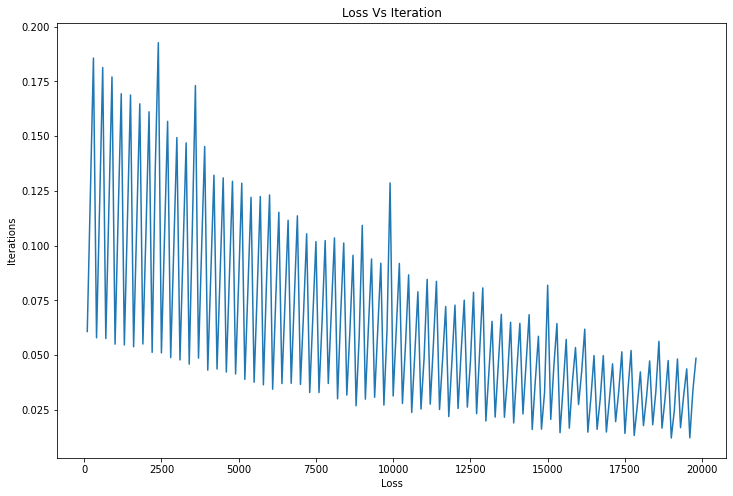

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 8)
x= np.array(iterations)
y= np.array(Loss)
plt.plot(x, y)
plt.title("Loss Vs Iteration")
plt.xlabel("Loss")
plt.ylabel("Iterations")
from google.colab import files
plt.savefig("Loss Vs Iteration.png",dpi=199)

files.download("Loss Vs Iteration.png") 
plt.show()
